In [4]:
#derive stellar parameters using MOOG of iSpec and add the adjustment function
#created Feb 7th 2023

In [61]:
import os
import sys
import numpy as np
import logging
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
from multiprocessing import Pool

In [62]:
#your directory
ispec_dir = '/home/rzzhang/iSpec_v20201001/'
sys.path.insert(0, os.path.abspath(ispec_dir))
import ispec

indir   = ispec_dir + 'GES_spec/input/'
rvdir   = ispec_dir + 'GES_spec/rvc/'
normdir = ispec_dir + 'GES_spec/norm/'
outdir  = ispec_dir + 'GES_spec/results/'

In [63]:
#spectra list
#take one spectra as an example to analyse the code
specname  = ['ADP.2020-11-02T11_15_54.747']
objname   = ['CD -48 0245']
#Instrname = ['UVES']

In [64]:
#read spectrum, calculate and correct the RV

#create dataframe to record rv, rv_err
RV_list = pd.DataFrame(columns = ['archive file name','Object','RV','RV_err'])

for i in range(1):
    logging.info("Reading spectra " + specname[i] + ' of ' + objname[i])
    star_spectrum = ispec.read_spectrum(indir + specname[i] + '.dat')
    #logging.info("Ploting spectra " + specname[i])
    #plt.plot(star_spectrum['waveobs'],star_spectrum['flux'])
    
    
    #--- Radial Velocity determination with linelist mask --------------------------
    logging.info("Radial velocity determination with linelist mask...")
    # - Read atomic data
    mask_file = ispec_dir + "input/linelists/CCF/Narval.Sun.370_1048nm/mask.lst"
    #mask_file = ispec_dir + "input/linelists/CCF/Atlas.Arcturus.372_926nm/mask.lst""
    #mask_file = ispec_dir + "input/linelists/CCF/Atlas.Sun.372_926nm/mask.lst"
    #mask_file = ispec_dir + "input/linelists/CCF/HARPS_SOPHIE.A0.350_1095nm/mask.lst"
    #mask_file = ispec_dir + "input/linelists/CCF/HARPS_SOPHIE.F0.360_698nm/mask.lst"
    #mask_file = ispec_dir + "input/linelists/CCF/HARPS_SOPHIE.G2.375_679nm/mask.lst"
    #mask_file = ispec_dir + "input/linelists/CCF/HARPS_SOPHIE.K0.378_679nm/mask.lst"
    #mask_file = ispec_dir + "input/linelists/CCF/HARPS_SOPHIE.K5.378_680nm/mask.lst"
    #mask_file = ispec_dir + "input/linelists/CCF/HARPS_SOPHIE.M5.400_687nm/mask.lst"
    #mask_file = ispec_dir + "input/linelists/CCF/Synthetic.Sun.350_1100nm/mask.lst"
    #mask_file = ispec_dir + "input/linelists/CCF/VALD.Sun.300_1100nm/mask.lst"
    ccf_mask = ispec.read_cross_correlation_mask(mask_file)
    
    #take 1.0 as the step for rough measurement
    logging.info("First run, from -500 to 500...")
    models0, ccf0 = ispec.cross_correlate_with_mask(star_spectrum, ccf_mask, \
                            lower_velocity_limit=-500, upper_velocity_limit=500, \
                            velocity_step=1.0, mask_depth=0.01, \
                            fourier=False)
    
    #read the rv results from the rough measurement
    x0 = np.argmin(ccf0['y'])
    rv0 = ccf0['x'][x0]
    print(rv0)
    
    #take 0.1 as the step for fine measurement around the rv0
    logging.info("Second run, from " + str(rv0-10) + ' to ' + str(rv0+10) + '...')
    models, ccf = ispec.cross_correlate_with_mask(star_spectrum, ccf_mask, \
                            lower_velocity_limit=rv0-10, upper_velocity_limit=rv0+10, \
                            velocity_step=0.1, mask_depth=0.01, \
                            fourier=False)
    
    # Number of models represent the number of components
    components = len(models)
    # First component:
    rv = models[0].mu() # km/s
    rv_err = models[0].emu() # km/s
    print(rv, rv_err)
    
    RV_list.loc[i] = [specname[i],objname[i],rv,rv_err]

    #keep 2 decimals
    #rv2 = np.round(models[0].mu(), 2) # km/s
    #rv_err2 = np.round(models[0].emu(), 2) # km/s
    
    #--- Radial Velocity correction ------------------------------------------------
    logging.info("Radial velocity correction...")
    RVcorr_spectrum = ispec.correct_velocity(star_spectrum, rv)
    
    #--- Save corrected spectrum ------------------------------------------------
    logging.info("Saving spectrum...")
    ispec.write_spectrum(RVcorr_spectrum, rvdir + specname[i] + "_rvc.fits")
    
    

[2023-02-13 04:27:56,798] [INFO] [3510242928:<cell line: 6>:7]: Reading spectra ADP.2020-11-02T11_15_54.747 of CD -48 0245
[2023-02-13 04:27:57,015] [INFO] [3510242928:<cell line: 6>:14]: Radial velocity determination with linelist mask...
[2023-02-13 04:27:57,329] [INFO] [3510242928:<cell line: 6>:30]: First run, from -500 to 500...
[2023-02-13 04:27:57,482] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 0.00%
[2023-02-13 04:27:57,522] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 10.09%
[2023-02-13 04:27:57,569] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 20.18%
[2023-02-13 04:27:57,617] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 30.27%
[2023-02-13 04:27:57,664] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 40.36%
[2023-02-13 04:27:57,718] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 50.45%
[2023-02-13 04:27:57,768] [INFO] [lines:__cross

329.0


[2023-02-13 04:27:58,324] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 0.00%
[2023-02-13 04:27:58,636] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 10.45%
[2023-02-13 04:27:58,897] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 20.90%
[2023-02-13 04:27:59,182] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 40.30%
[2023-02-13 04:27:59,426] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 50.75%
[2023-02-13 04:27:59,920] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 70.15%
[2023-02-13 04:28:00,156] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 80.60%
[2023-02-13 04:28:00,422] [INFO] [lines:__model_velocity_profile:2455]: Peak found at 328.90 km/s (fitted at 328.94 +/- 0.09 km/s)
[2023-02-13 04:28:00,424] [INFO] [3510242928:<cell line: 6>:62]: Radial velocity correction...
[2023-02-13 04:28:00,425] [INFO] [3510242928:<cell lin

328.93992984908243 0.09309863775943567


In [65]:
RV_list

,archive file name,Object,RV,RV_err
0,ADP.2020-11-02T11_15_54.747,CD -48 0245,328.93993,0.093099


In [66]:
RV_list.to_csv(rvdir+'RV_list.csv', index=False)

In [12]:
#header of ccf_mask and select a row as an example
print(ccf_mask.dtype)
print(ccf_mask[500])

[('wave_peak', '<f8'), ('wave_base', '<f8'), ('wave_top', '<f8'), ('note', '<i8'), ('peak', '<i8'), ('base', '<i8'), ('top', '<i8'), ('depth', '<f8'), ('relative_depth', '<f8'), ('wave_base_fit', '<f8'), ('wave_top_fit', '<f8'), ('base_fit', '<i8'), ('top_fit', '<i8'), ('mu', '<f8'), ('sig', '<f8'), ('A', '<f8'), ('baseline', '<f8'), ('gamma', '<f8'), ('mu_err', '<f8'), ('fwhm', '<f8'), ('fwhm_kms', '<f8'), ('R', '<f8'), ('depth_fit', '<f8'), ('relative_depth_fit', '<f8'), ('integrated_flux', '<f8'), ('ewr', '<f8'), ('ew', '<f8'), ('ew_err', '<f8'), ('rms', '<f8'), ('telluric_wave_peak', '<f8'), ('telluric_fwhm', '<f8'), ('telluric_R', '<f8'), ('telluric_depth', '<f8'), ('wave (nm)', '<f8'), ('wave (A)', '<f8'), ('species', '<f8'), ('element', '<U4'), ('lower state (cm^-1)', '<i8'), ('upper state (cm^-1)', '<i8'), ('lower state (eV)', '<f8'), ('upper state (eV)', '<f8'), ('log(gf)', '<f8'), ('fudge factor', '<f8'), ('transition type', '<U2'), ('rad', '<f8'), ('stark', '<f8'), ('waals',

In [13]:
#Find which elements the mask uses
ccf_ele = ccf_mask['element']
np.unique(ccf_ele, return_counts=True)

(masked_array(data=['Ag 1', 'Al 1', 'Al 2', 'Al 3', 'Ar 1', 'Ar 2', 'Ba 1',
                    'Ba 2', 'Be 2', 'C 1', 'C 2', 'C 3', 'Ca 1', 'Ca 2',
                    'Ca 3', 'Ce 1', 'Ce 2', 'Ce 3', 'Cl 1', 'Cl 2', 'Co 1',
                    'Co 2', 'Co 3', 'Co 4', 'Cr 1', 'Cr 2', 'Cr 3', 'Cu 1',
                    'Cu 2', 'Dy 1', 'Dy 2', 'Er 1', 'Er 2', 'Eu 1', 'Eu 2',
                    'Eu 3', 'F 1', 'F 2', 'F 3', 'Fe 1', 'Fe 2', 'Fe 3',
                    'Fe 4', 'Fe 5', 'Gd 1', 'Gd 2', 'Ge 1', 'Ge 2', 'He 1',
                    'Hf 1', 'Hf 2', 'Ho 2', 'Ho 3', 'In 1', 'Ir 1', 'K 1',
                    'La 1', 'La 2', 'Li 1', 'Lu 1', 'Lu 2', 'Lu 3', 'Mg 1',
                    'Mg 2', 'Mn 1', 'Mn 2', 'Mn 3', 'Mo 1', 'Mo 2', 'N 1',
                    'N 2', 'N 3', 'N 5', --, 'Na 1', 'Nb 1', 'Nb 2',
                    'Nd 1', 'Nd 2', 'Nd 3', 'Ne 1', 'Ne 2', 'Ni 1', 'Ni 2',
                    'Ni 3', 'Ni 4', 'Ni 5', 'O 1', 'O 2', 'O 3', 'Os 1',
                    'P 1', 'P 

(numpy.record, [('x', '<f8'), ('y', '<f8'), ('err', '<f8')])


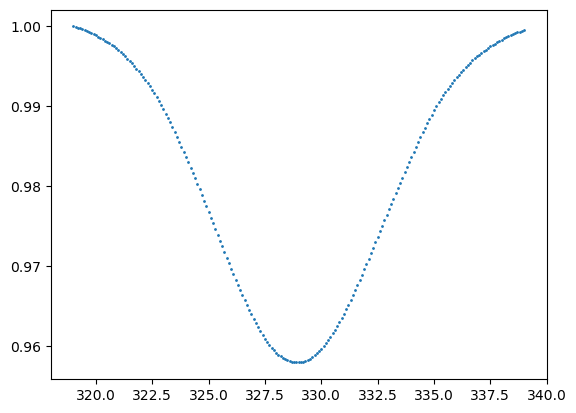

In [21]:
#plt the RV fitting results
print(ccf.dtype)
plt.scatter(ccf['x'],ccf['y'],s=1)

In [44]:
#plt the RV fitting results
help(models[0])
print(models[0].mu(),models[0].emu())

Help on GaussianModel in module ispec.modeling.mpfitmodels object:

class GaussianModel(MPFitModel)
 |  GaussianModel(baseline=0, A=-0.025, sig=0.25, mu=0)
 |  
 |  Method resolution order:
 |      GaussianModel
 |      MPFitModel
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  A(self)
 |  
 |  __init__(self, baseline=0, A=-0.025, sig=0.25, mu=0)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  baseline(self)
 |  
 |  eA(self)
 |  
 |  ebaseline(self)
 |  
 |  emu(self)
 |  
 |  esig(self)
 |  
 |  fitData(self, x, y, weights=None, parinfo=None)
 |      - ftol: Termination occurs when both the actual
 |              and predicted relative reductions in the sum of squares are at most
 |              ftol
 |      - xtol: Termination occurs when the relative error
 |              between two consecutive iterates is at most xtol
 |      - gtol: Termination occurs when the cosine of
 |              the angle between fvec and any column of the j